<a href="https://colab.research.google.com/github/CA683-Group99/Wind-Energy-Prediction/blob/main/4_IslandElectricityANNModel_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [96]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/CA683Project')
# CL os.chdir('/content/drive/MyDrive/Colab Notebooks/CA683Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
import pandas as pd

inFilename = 'IslandElectricity2017_2020v4.csv'
filePath = 'Data/' + inFilename
# CL inData = pd.read_csv(filePath)
inData = pd.read_csv(inFilename)

print('-----------DATA INFO -------------')
print(inData.info())

display(inData.head())


inData.date = pd.to_datetime(inData.date, format='%Y-%m-%d %H:%M', errors='ignore')
inData.isweekday = inData.isweekday.astype('bool')

-----------DATA INFO -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32136 entries, 0 to 32135
Data columns (total 94 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           32136 non-null  int64  
 1   date                 32136 non-null  object 
 2   ind_BEL              32136 non-null  int64  
 3   rain_BEL             32136 non-null  float64
 4   ind.1_BEL            32136 non-null  int64  
 5   temp_BEL             32136 non-null  float64
 6   ind.2_BEL            32136 non-null  int64  
 7   wetb_BEL             32136 non-null  float64
 8   dewpt_BEL            32136 non-null  float64
 9   vappr_BEL            32136 non-null  float64
 10  rhum_BEL             32136 non-null  int64  
 11  msl_BEL              32136 non-null  float64
 12  ind.3_BEL            32136 non-null  int64  
 13  wdsp_BEL             32136 non-null  int64  
 14  ind.4_BEL            32136 non-null  int64  
 15  w

,Unnamed: 0,date,ind_BEL,rain_BEL,ind.1_BEL,temp_BEL,ind.2_BEL,wetb_BEL,dewpt_BEL,vappr_BEL,rhum_BEL,msl_BEL,ind.3_BEL,wdsp_BEL,ind.4_BEL,wddir_BEL,ww_BEL,w_BEL,sun_BEL,vis_BEL,clht_BEL,clamt_BEL,ind_DUB,rain_DUB,ind.1_DUB,temp_DUB,ind.2_DUB,wetb_DUB,dewpt_DUB,vappr_DUB,rhum_DUB,msl_DUB,ind.3_DUB,wdsp_DUB,ind.4_DUB,wddir_DUB,ww_DUB,w_DUB,sun_DUB,vis_DUB,...,ind.4,wddir,ww,w,sun,vis,clht,clamt,ind_COR,rain_COR,ind.1_COR,temp_COR,ind.2_COR,wetb_COR,dewpt_COR,vappr_COR,rhum_COR,msl_COR,ind.3_COR,wdsp_COR,ind.4_COR,wddir_COR,ww_COR,w_COR,sun_COR,vis_COR,clht_COR,clamt_COR,Unnamed: 0.1,ActualDemandMW,ForecastWndMW,ActualWindMW,ActualGenerationMW,NetTotal_MW,WindMWPercent,hour,isweekday,month,year,TotalWindCapacityMW
0,0,2017-07-01 00:00:00,0,0.0,0,12.3,0,11.3,10.3,12.5,88,1017.6,2,8,2,200,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,8.5,0,7.4,6.2,9.4,85.0,1018.0,2,7,2,270.0,2,11,0.0,40000,...,2,260,2,11,0.0,30000,999,0,3,0.0,0,10.0,0,8.7,7.2,10.2,83.0,1020.7,2,7,2,280,2,11,0.0,30000.0,999,2,0.0,2394.75,287.0,280.25,2580.75,-221.00,11.702683,0.0,False,7.0,2017.0,4096.494
1,1,2017-07-01 01:00:00,0,0.0,0,12.5,0,11.4,10.4,12.6,87,1016.9,2,10,2,200,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,8.0,0,7.0,5.9,9.2,86.0,1018.2,2,9,2,270.0,2,11,0.0,40000,...,2,240,2,11,0.0,30000,999,2,3,0.0,0,9.6,0,8.3,6.8,9.9,83.0,1020.5,2,7,2,280,2,11,0.0,30000.0,999,1,1.0,2961.50,319.5,423.25,3402.00,-406.75,14.291744,1.0,False,7.0,2017.0,4096.494
2,2,2017-07-01 02:00:00,0,0.0,0,13.0,0,11.9,10.9,13.0,86,1016.2,2,14,2,200,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,7.5,0,6.9,6.2,9.5,91.0,1018.0,2,8,2,270.0,2,11,0.0,40000,...,2,190,2,11,0.0,30000,999,2,3,0.0,0,9.7,0,8.4,7.0,10.0,83.0,1020.2,2,7,2,280,2,11,0.0,30000.0,999,1,2.0,2785.25,320.0,451.25,3411.75,-388.00,16.201418,2.0,False,7.0,2017.0,4096.494
3,3,2017-07-01 03:00:00,0,0.0,0,12.9,0,12.0,11.2,13.3,89,1015.6,2,16,2,210,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,7.2,0,6.7,6.1,9.4,93.0,1018.0,2,9,2,270.0,2,11,0.0,60000,...,2,190,2,11,0.0,20000,23,7,3,0.0,0,8.8,0,7.9,6.9,9.9,88.0,1019.9,2,4,2,280,2,11,0.0,30000.0,999,1,3.0,2716.25,347.5,512.75,3500.00,-534.75,18.877128,3.0,False,7.0,2017.0,4096.494
4,4,2017-07-01 04:00:00,0,0.0,0,13.3,0,12.7,12.2,14.2,93,1015.0,2,17,2,210,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,7.6,0,7.0,6.3,9.5,91.0,1017.7,2,8,2,250.0,2,11,0.0,60000,...,2,170,2,11,0.0,20000,23,7,3,0.0,0,8.5,0,7.6,6.6,9.7,88.0,1019.6,2,5,2,270,2,11,0.0,30000.0,18,5,4.0,2654.00,410.5,576.75,3330.00,-430.50,21.731349,4.0,False,7.0,2017.0,4096.494


## Transform wind speed and dir into 2D wind vector

In [98]:
import math

suffixes = ['_COR', '_DUB', '_BEL', '']
def transformWindInto2d(df):
  for suf in suffixes:
    df['wind' + suf + 'sin'] = None
    df['wind' + suf + 'cos'] = None

  def transformWindInto2dRow(row):
    for suf in suffixes:
      row['wind' + suf + 'sin'] = row['wdsp'+ suf] * math.sin(row['wddir' + suf])
      row['wind' + suf + 'cos'] = row['wdsp'+ suf] * math.cos(row['wddir' + suf])
    return row

  df = df.apply(transformWindInto2dRow, axis='columns')
  return df

inData = transformWindInto2d(inData)
inData.columns

Index(['Unnamed: 0', 'date', 'ind_BEL', 'rain_BEL', 'ind.1_BEL', 'temp_BEL',
       'ind.2_BEL', 'wetb_BEL', 'dewpt_BEL', 'vappr_BEL',
       ...
       'year', 'TotalWindCapacityMW', 'wind_CORsin', 'wind_CORcos',
       'wind_DUBsin', 'wind_DUBcos', 'wind_BELsin', 'wind_BELcos', 'windsin',
       'windcos'],
      dtype='object', length=102)

Text(0, 0.5, 'Wind Velocity [m/s]')

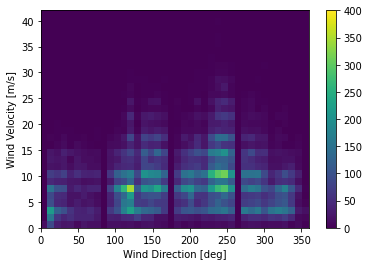

In [99]:
import matplotlib.pyplot as plt
plt.hist2d(inData['wddir'], inData['wdsp'], bins=(40, 30), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

## Transform time into 2D

Intend to capture the seasonal pattern

In [100]:
import numpy as np
import math

def transformTimeInto2d(df):
  df['Day_inYear'] = None
  df['daysInYear'] = None
  df['radianTime'] = None
  df['radianTimeCos'] = None
  df['radianTimeSin'] = None

  def check_leap(year):
    if year%4 == 0:
      return 366
    else:
      return 365

  def transformTimeInto2dRow(row):
    row['Day_inYear'] = row['date'].timetuple().tm_yday
    daysInYear = check_leap(row['year'])
    row['daysInYear'] = daysInYear
    row['radianTime'] = (row.hour + row.Day_inYear * 24 ) / (24 * daysInYear) * (2*np.pi)
    row['radianTimeCos'] = math.cos(row['radianTime'])
    row['radianTimeSin'] = math.sin(row['radianTime'])
    return row

  df = df.apply(transformTimeInto2dRow, axis='columns')
  return df

inData = transformTimeInto2d(inData)
inData.columns

Index(['Unnamed: 0', 'date', 'ind_BEL', 'rain_BEL', 'ind.1_BEL', 'temp_BEL',
       'ind.2_BEL', 'wetb_BEL', 'dewpt_BEL', 'vappr_BEL',
       ...
       'wind_DUBcos', 'wind_BELsin', 'wind_BELcos', 'windsin', 'windcos',
       'Day_inYear', 'daysInYear', 'radianTime', 'radianTimeCos',
       'radianTimeSin'],
      dtype='object', length=107)

# Data preperation

## Select data for training and testing

In [101]:
# CL END CHANGE 

In [102]:
# CL Change : take all data


# (inData.year<=2021)
dataSet = inData.loc[(inData.year>=2017) & (inData.date < "2021-03-01"), ['date', 'hour', 'month', 'year', 'Day_inYear',
                                                                  'wdsp_BEL', 'wddir_BEL', 'wind_BELsin', 'wind_BELcos', 'vappr_BEL', 'rhum', 'temp_BEL',
                                                                  'wdsp', 'wddir', 'windsin', 'windcos', 'vappr', 'rhum', 'temp', 'msl',
                                                                  'wdsp_COR', 'wddir_COR', 'wind_CORsin', 'wind_CORcos', 'vappr_COR', 'rhum_COR', 'temp_COR',
                                                                  'wdsp_DUB', 'wddir_DUB', 'wind_DUBsin', 'wind_DUBcos', 'vappr_DUB', 'rhum_DUB', 'temp_DUB',
                                                                  'TotalWindCapacityMW',
                                                                  'radianTimeSin', 'radianTimeCos',
                                                                  'ActualWindMW', 'ActualDemandMW', 'ForecastWndMW']]

## Handle the rows with empty values

In [103]:
# CL Change : fill in missing Rhum and vappr values as quick fix
dataSet.isnull().sum()

date                    0
hour                    0
month                   0
year                    0
Day_inYear              0
wdsp_BEL                0
wddir_BEL               0
wind_BELsin             0
wind_BELcos             0
vappr_BEL               0
rhum                   84
temp_BEL                0
wdsp                    0
wddir                   0
windsin                 0
windcos                 0
vappr                  84
rhum                   84
temp                    0
msl                     0
wdsp_COR                0
wddir_COR               0
wind_CORsin             0
wind_CORcos             0
vappr_COR              84
rhum_COR               84
temp_COR                0
wdsp_DUB                0
wddir_DUB               1
wind_DUBsin             1
wind_DUBcos             1
vappr_DUB              84
rhum_DUB               84
temp_DUB                0
TotalWindCapacityMW     0
radianTimeSin           0
radianTimeCos           0
ActualWindMW            0
ActualDemand

In [104]:
dataSet.fillna(method='ffill', inplace=True)

In [105]:
dataSet.isnull().sum()



date                   0
hour                   0
month                  0
year                   0
Day_inYear             0
wdsp_BEL               0
wddir_BEL              0
wind_BELsin            0
wind_BELcos            0
vappr_BEL              0
rhum                   0
temp_BEL               0
wdsp                   0
wddir                  0
windsin                0
windcos                0
vappr                  0
rhum                   0
temp                   0
msl                    0
wdsp_COR               0
wddir_COR              0
wind_CORsin            0
wind_CORcos            0
vappr_COR              0
rhum_COR               0
temp_COR               0
wdsp_DUB               0
wddir_DUB              0
wind_DUBsin            0
wind_DUBcos            0
vappr_DUB              0
rhum_DUB               0
temp_DUB               0
TotalWindCapacityMW    0
radianTimeSin          0
radianTimeCos          0
ActualWindMW           0
ActualDemandMW         0
ForecastWndMW          0


In [106]:
# dataSet.fillna(method='ffill', limit=4, inplace=True)

# Remove the rows with empty cells
import numpy as np
eIdx = np.where(pd.isnull(dataSet))
print(eIdx[0])

print(dataSet.shape)
dataSet = dataSet.drop(eIdx[0], axis=0)
print(dataSet.shape)

[]
(32136, 40)
(32136, 40)


## Different feature sets to build different ANN models

In [107]:
# CL: 2021/04/02: remove Hour as very highly correlated with Day_inYear, as well as temp other than temp_DUB
# and add 'msl' Sea Level pressure as highly predictive of upcoming storm and improve wind turbine performance
attr_basic = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL', 
              'wdsp', 'wddir', 'msl',
              'wdsp_COR', 'wddir_COR',
              'wdsp_DUB', 'wddir_DUB', 'temp_DUB',
              'TotalWindCapacityMW']

attr_rhum = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL', 'rhum', 
              'wdsp', 'wddir', 'rhum', 'msl',
              'wdsp_COR', 'wddir_COR', 'rhum_COR',
              'wdsp_DUB', 'wddir_DUB', 'rhum_DUB', 'temp_DUB',
              'TotalWindCapacityMW']

attr_vappr = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL', 'vappr_BEL', 
              'wdsp', 'wddir', 'vappr','msl', 'msl',
              'wdsp_COR', 'wddir_COR', 'vappr_COR',
              'wdsp_DUB', 'wddir_DUB', 'vappr_DUB', 'temp_DUB',
              'TotalWindCapacityMW']

attr_rhum_vappr = ['hour', 'Day_inYear',
                    'wdsp_BEL', 'wddir_BEL', 'rhum', 'vappr_BEL', 
                    'wdsp', 'wddir', 'rhum', 'vappr', 'msl',
                    'wdsp_COR', 'wddir_COR', 'rhum_COR', 'vappr_COR',
                    'wdsp_DUB', 'wddir_DUB', 'rhum_DUB', 'vappr_DUB', 'temp_DUB',
                    'TotalWindCapacityMW']

attr_2D_wind = ['hour', 'Day_inYear',
                'wind_BELsin', 'wind_BELcos', 
                'windsin', 'windcos', 'msl',
                'wind_CORsin', 'wind_CORcos',
                'wind_DUBsin', 'wind_DUBcos', 'temp_DUB',
                'TotalWindCapacityMW']

attr_radianTime = ['hour', 'wdsp_BEL', 'wddir_BEL', 
                    'wdsp', 'wddir', 'msl',
                    'wdsp_COR', 'wddir_COR',
                    'wdsp_DUB', 'wddir_DUB', 'temp_DUB',
                    'radianTimeSin', 'radianTimeCos',
                    'TotalWindCapacityMW']

attr_2D_wind_time = ['hour', 'wind_BELsin', 'wind_BELcos', 
                      'windsin', 'windcos', 'msl',
                      'wind_CORsin', 'wind_CORcos', 
                      'wind_DUBsin', 'wind_DUBcos', 'temp_DUB', 
                      'radianTimeSin', 'radianTimeCos',
                      'TotalWindCapacityMW']


attr_selections = [attr_basic, attr_rhum, attr_vappr, attr_rhum_vappr, attr_2D_wind, attr_radianTime, attr_2D_wind_time]
attrSet_names = ['basic', 'rhum', 'vappr', 'rhum & vappr', 'wind', 'radianTime', 'wind & time']



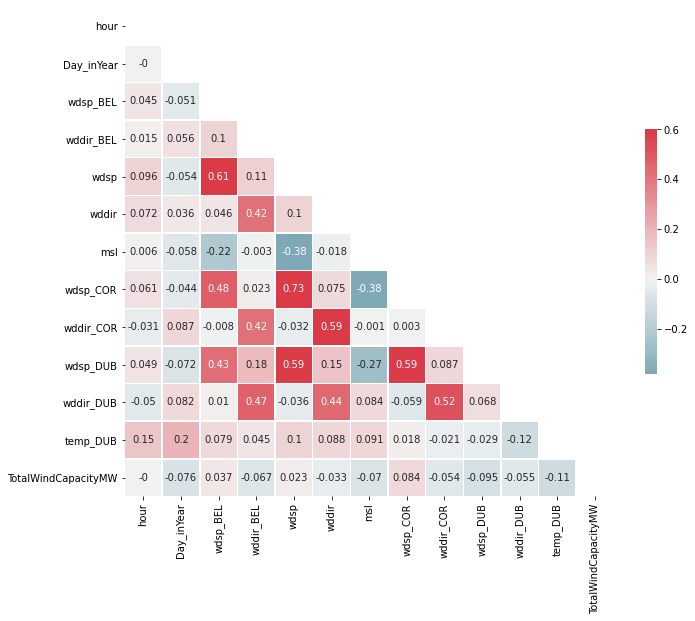

In [108]:
import seaborn as sns

num_df = dataSet.loc[:, attr_basic].select_dtypes(['int', 'float'])
# Compute the correlation matrix
corr = num_df.corr()
corr = np.round(corr, 3)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.6, center=0, annot= True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [109]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.api import add_constant

num_df = add_constant(num_df)

vif = [variance_inflation_factor(num_df.to_numpy(), i) for i in range(num_df.to_numpy().shape[1])]

pd.DataFrame(num_df.iloc[:, 1:].columns, vif[1:])

,0
1.040868,hour
1.090057,Day_inYear
1.619126,wdsp_BEL
1.462983,wddir_BEL
2.966044,wdsp
1.751329,wddir
1.259076,msl
2.464410,wdsp_COR
1.852760,wddir_COR
1.829920,wdsp_DUB


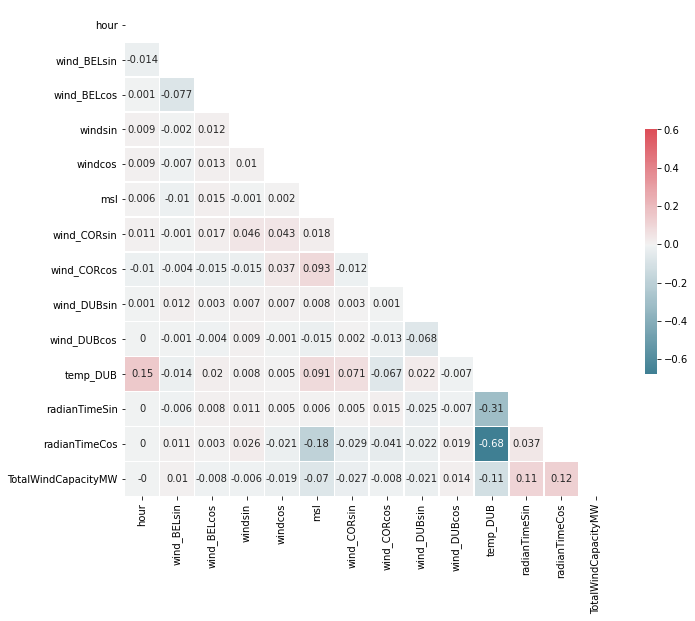

In [110]:
num_df = dataSet.loc[:, attr_2D_wind_time].select_dtypes(['int', 'float'])
# Compute the correlation matrix
corr = num_df.corr()
corr = np.round(corr, 3)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.6, center=0, annot= True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [111]:
num_df = add_constant(num_df)

vif = [variance_inflation_factor(num_df.to_numpy(), i) for i in range(num_df.to_numpy().shape[1])]

pd.DataFrame(num_df.iloc[:, 1:].columns, vif[1:])

,0
1.051019,hour
1.006696,wind_BELsin
1.008312,wind_BELcos
1.004884,windsin
1.004497,windcos
1.048048,msl
1.011807,wind_CORsin
1.028704,wind_CORcos
1.006150,wind_DUBsin
1.005461,wind_DUBcos


# Training, Validation & Test set

In [112]:
dataSet.shape

(32136, 40)

In [113]:
from sklearn.model_selection import train_test_split
import numpy as np

splitOption = 1

testSet = dataSet.loc[(inData.date > "2021-02-14"), :]
mainSet = dataSet.loc[(inData.date <= "2021-02-14"), :]

if (splitOption == 0):
  trainSet, validSet = train_test_split(mainSet, test_size=0.2, random_state=42)
elif (splitOption == 1):  # split per day of the month
  dataSet["dayInMonth"] = 0

  def setDayInMonth(row):
      row["dayInMonth"] = row.date.day
      return row

  dataSet = dataSet.apply(setDayInMonth, axis=1)

  trainSet = dataSet.loc[(dataSet.dayInMonth > 0) & (dataSet.dayInMonth < 23), :]
  validSet = dataSet.loc[(dataSet.dayInMonth >= 23) & (inData.date <= "2021-02-22"), :]

else:
  monthYear = []
  for y in range(2017,2021):
    for m in range(1,13):
     monthYear.append([m, y])
  trainDate, validDate = train_test_split(monthYear, test_size=0.2, random_state=42)

  trainDate = np.array(trainDate)
  validDate = np.array(validDate)

  trainSet = dataSet.loc[(dataSet.month in trainDate[:,0]) & (dataSet.year in trainDate[:,1]), :]
  validSet = dataSet.loc[(dataSet.month in validDate[:,0]) & (dataSet.year in validDate[:,1]), :]

y_train = trainSet.ActualWindMW
y_valid = validSet.ActualWindMW
y_test = testSet.ActualWindMW

In [114]:
trainSet.shape, validSet.shape, testSet.shape

((23232, 41), (8760, 41), (359, 40))

# Models

## ANN model

### Set up model for each feature set

In [115]:
import tensorflow as tf
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt

# tf.config.list_physical_devices("GPU")
print(tf.test.gpu_device_name())

tf.random.set_seed(42)

# Callback function to stop the training when no further performance gain
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

/device:GPU:0


### Preprocessing

Scaling the training and validation data using `StandardScaler` (gave better results)

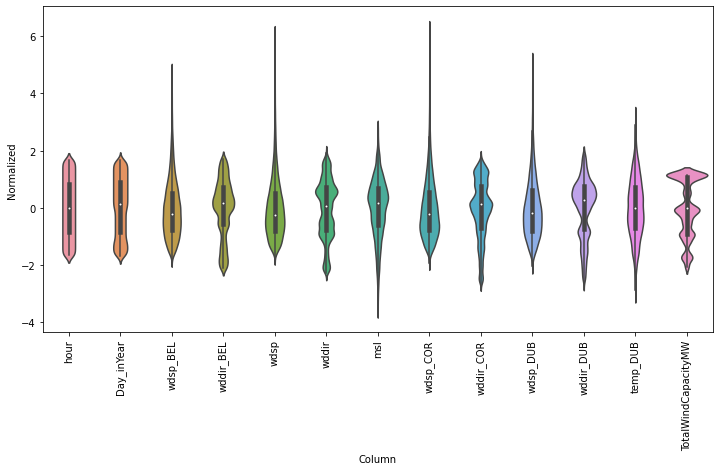

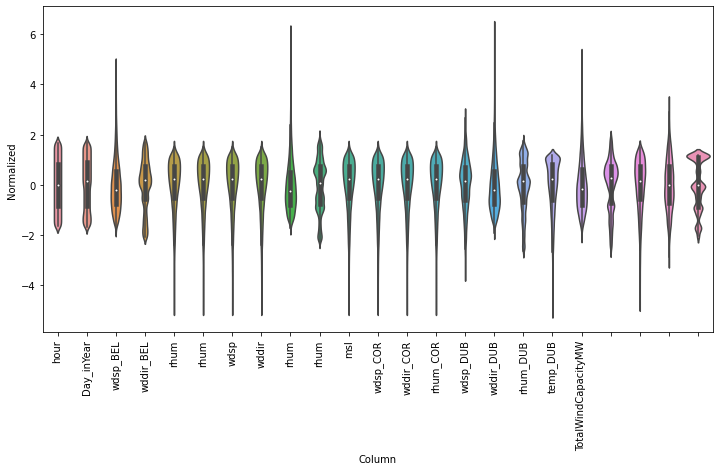

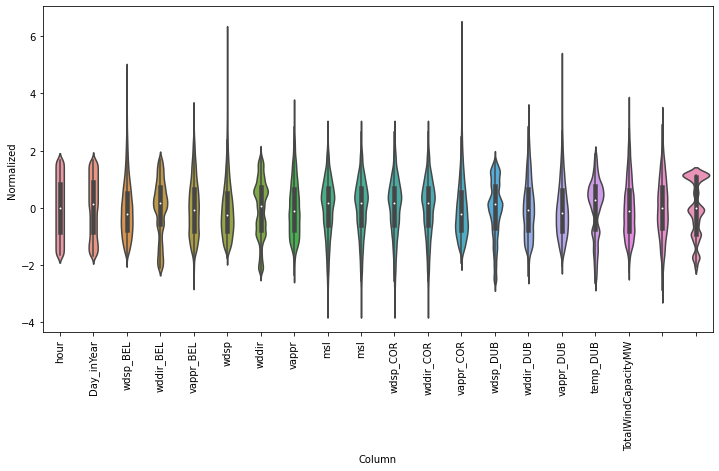

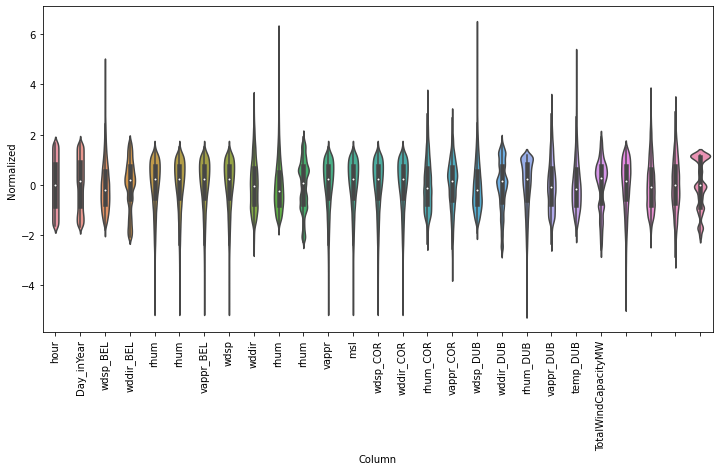

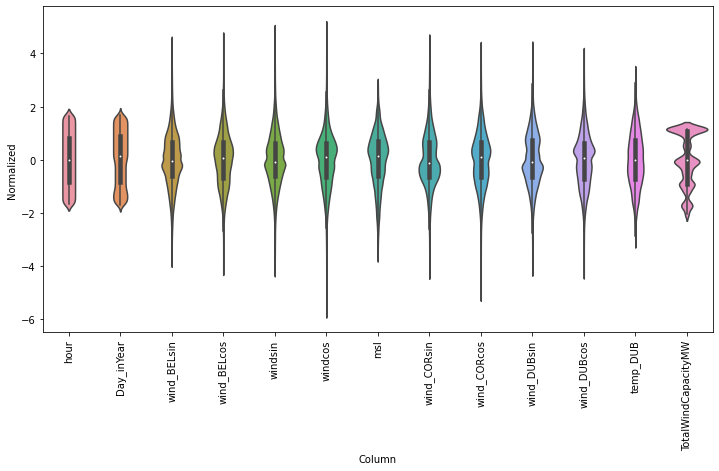

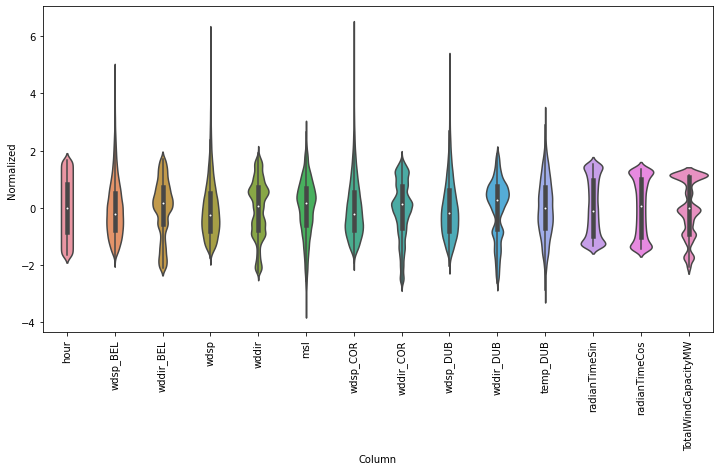

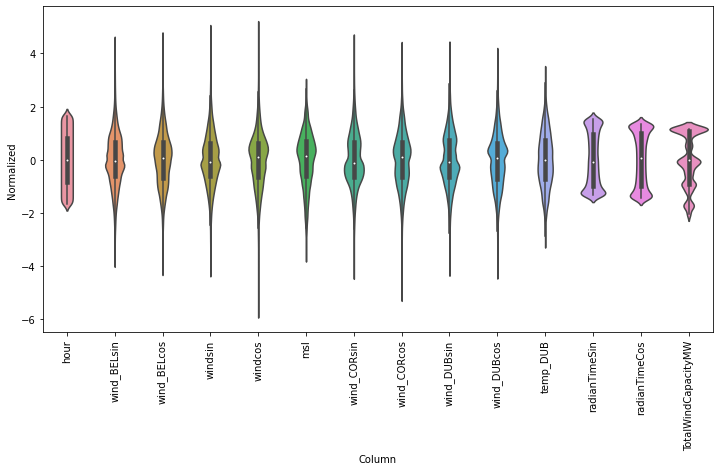

In [116]:
attr_set = {}
ct_set = {}
train_set = {}
valid_set = {}
test_set = {}

for i in range(0,len(attrSet_names)):
    X_train = trainSet.loc[:, attr_selections[i]]
    X_valid = validSet.loc[:, attr_selections[i]]
    X_test = testSet.loc[:, attr_selections[i]]

    ct = make_column_transformer((StandardScaler(), attr_selections[i]))
    ct.fit(X_train)  

    attr_set[attrSet_names[i]] = attr_selections[i]
    ct_set[attrSet_names[i]] = ct
    train_set[attrSet_names[i]] = X_train
    valid_set[attrSet_names[i]] = X_valid
    test_set[attrSet_names[i]] = X_test

    # Visual features validation
    df = dataSet.loc[:, attr_selections[i]]

    df_std = pd.DataFrame(ct.transform(df))
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
    _ = ax.set_xticklabels(df.keys(), rotation=90)

In [117]:
attrSet_names

['basic', 'rhum', 'vappr', 'rhum & vappr', 'wind', 'radianTime', 'wind & time']

### Model fitting

In [118]:
# saving the feature_sets, models, column_transformer, evaluation history & validation set
eval_hist = {}
models = {}

# train the model for each feature set

for i in attrSet_names:

  ann = tf.keras.models.Sequential([
            tf.keras.layers.Dense(units=100, activation='relu', name="Layer_1"),
            tf.keras.layers.Dense(units=10, activation='relu', name="Layer_2"),
            tf.keras.layers.Dense(units=1, name="output_layer")
            ])

  ann.compile(loss=tf.keras.losses.mae, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.Adam(lr=0.01), # sgd is short for stochasitc gradient descent
              metrics=["mae"])
  
  X_train = train_set[i]
  X_valid = valid_set[i]
  ct = ct_set[i]
  
  X_train_normal = ct.transform(X_train)
  X_valid_normal = ct.transform(X_valid)

  print('------------------------------------------------------------ ' + i + ' ---------------------------------------------------------------------------')
  with tf.device('/device:GPU:0'):
    history = ann.fit(X_train_normal, y_train, epochs = 40, validation_data=(X_valid_normal,y_valid), callbacks=[es])

  eval_hist[i] = history
  models[i] = ann

------------------------------------------------------------ basic ---------------------------------------------------------------------------
Epoch 1/40
726/726 [==============================] - 2s 2ms/step - loss: 707.0767 - mae: 707.0767 - val_loss: 334.7051 - val_mae: 334.7051
Epoch 2/40
726/726 [==============================] - 2s 2ms/step - loss: 331.9692 - mae: 331.9692 - val_loss: 328.7133 - val_mae: 328.7133
Epoch 3/40
726/726 [==============================] - 2s 2ms/step - loss: 326.4666 - mae: 326.4666 - val_loss: 320.1492 - val_mae: 320.1492
Epoch 4/40
726/726 [==============================] - 2s 2ms/step - loss: 322.7085 - mae: 322.7085 - val_loss: 316.3339 - val_mae: 316.3339
Epoch 5/40
726/726 [==============================] - 2s 2ms/step - loss: 301.9483 - mae: 301.9483 - val_loss: 297.7870 - val_mae: 297.7870
Epoch 6/40
726/726 [==============================] - 2s 2ms/step - loss: 289.5097 - mae: 289.5097 - val_loss: 289.9885 - val_mae: 289.9885
Epoch 7/40
726/72

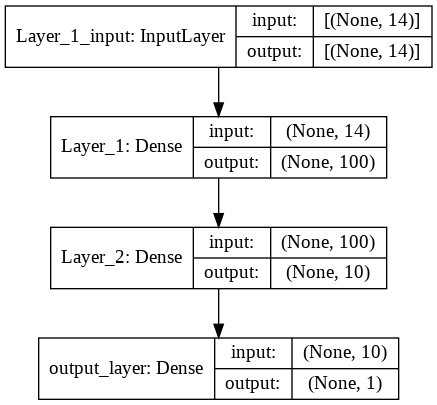

In [130]:
# Plot model for RadianTime subset (14 features)
from tensorflow.python.keras.utils.vis_utils import plot_model

plot_model(models['radianTime'], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Plot the learning curve for each ANN model

In [119]:
import plotly.express as px

hist = pd.DataFrame(columns=['loss', 'epoch', 'model']);
for attr in eval_hist.keys():
  temp = pd.DataFrame(columns=['loss', 'epoch', 'model'])
  temp['loss'] = eval_hist[attr].history['loss']
  temp['epoch'] = np.arange(1,len(temp.loss)+1)
  temp['model'] = attr
  hist = pd.concat([hist, temp],ignore_index=True)

fig = px.line(hist, x="epoch", y="loss", color='model')
fig.show()

In [120]:
eval_hist

{'basic': <tensorflow.python.keras.callbacks.History at 0x7f5d64a99910>,
 'radianTime': <tensorflow.python.keras.callbacks.History at 0x7f5d554c7950>,
 'rhum': <tensorflow.python.keras.callbacks.History at 0x7f5d588117d0>,
 'rhum & vappr': <tensorflow.python.keras.callbacks.History at 0x7f5d5ead6a10>,
 'vappr': <tensorflow.python.keras.callbacks.History at 0x7f5d64042090>,
 'wind': <tensorflow.python.keras.callbacks.History at 0x7f5d5e94f790>,
 'wind & time': <tensorflow.python.keras.callbacks.History at 0x7f5d50aa6250>}

In [121]:
hist = pd.DataFrame(columns=['val_loss', 'epoch', 'model']);
for attr in eval_hist.keys():
  temp = pd.DataFrame(columns=['val_loss', 'epoch', 'model'])
  temp['val_loss'] = eval_hist[attr].history['val_loss']
  temp['epoch'] = np.arange(1,len(temp.val_loss)+1)
  temp['model'] = attr
  hist = pd.concat([hist, temp],ignore_index=True)

fig = px.line(hist, x="epoch", y="val_loss", color='model')
fig.show()

In [122]:

hist = pd.DataFrame(columns=['val_mae', 'epoch', 'model']);
for attr in eval_hist.keys():
  temp = pd.DataFrame(columns=['val_mae', 'epoch', 'model'])
  temp['val_mae'] = eval_hist[attr].history['val_mae']
  temp['epoch'] = np.arange(1,len(temp.val_mae)+1)
  temp['model'] = attr
  hist = pd.concat([hist, temp],ignore_index=True)

fig = px.line(hist, x="epoch", y="val_mae", color='model')
fig.show()

### Elvaluation metric for each model

In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for i in models.keys():
  ann = models[i]
  X_valid = valid_set[i]
  ct = ct_set[i]
  
  X_valid_normal = ct.transform(X_valid)
  preds = ann.predict(X_valid_normal)

  print('--------------------------------------- ' + i + ' -------------------------------------------')
  print('MAE:', mean_absolute_error(y_valid, preds))
  #print('mean_absolute_percentage_error: ', mean_absolute_percentage_error(y_valid, preds))
  print('RMSE:', np.sqrt(mean_squared_error(y_valid, preds))) 
  print('Test r2_score:', r2_score(y_valid, preds))

--------------------------------------- basic -------------------------------------------
MAE: 254.76401960561265
RMSE: 343.95940489411225
Test r2_score: 0.8661566235267365
--------------------------------------- rhum -------------------------------------------
MAE: 260.6725627603052
RMSE: 343.09580177036753
Test r2_score: 0.8668278797823142
--------------------------------------- vappr -------------------------------------------
MAE: 259.5176377642917
RMSE: 344.2134507109127
Test r2_score: 0.8659588391001163
--------------------------------------- rhum & vappr -------------------------------------------
MAE: 248.92589350029758
RMSE: 330.51992649633775
Test r2_score: 0.8764115739616549
--------------------------------------- wind -------------------------------------------
MAE: 284.228359485108
RMSE: 375.9486144767099
Test r2_score: 0.8401033063312874
--------------------------------------- radianTime -------------------------------------------
MAE: 249.094949114867
RMSE: 329.321765927

In [124]:
for i in models.keys():
  ann = models[i]
  X_test = test_set[i]
  ct = ct_set[i]
  
  X_test_normal = ct.transform(X_test)
  preds = ann.predict(X_test_normal)

  print('--------------------------------------- ' + i + ' -------------------------------------------')
  print('MAE:', mean_absolute_error(y_test, preds))
  #print('mean_absolute_percentage_error: ', mean_absolute_percentage_error(y_valid, preds))
  print('RMSE:', np.sqrt(mean_squared_error(y_test, preds))) 
  print('Test r2_score:', r2_score(y_test, preds))

--------------------------------------- basic -------------------------------------------
MAE: 250.80937539103303
RMSE: 323.8370189046714
Test r2_score: 0.909966455841837
--------------------------------------- rhum -------------------------------------------
MAE: 293.82209038269554
RMSE: 368.6922477878572
Test r2_score: 0.8832977114220164
--------------------------------------- vappr -------------------------------------------
MAE: 246.16317090217782
RMSE: 316.47688430118257
Test r2_score: 0.9140124946984136
--------------------------------------- rhum & vappr -------------------------------------------
MAE: 338.89303393350673
RMSE: 437.4156013173687
Test r2_score: 0.8357369439217277
--------------------------------------- wind -------------------------------------------
MAE: 294.3355814474207
RMSE: 377.5049428262101
Test r2_score: 0.8776520645266613
--------------------------------------- radianTime -------------------------------------------
MAE: 256.04758336484264
RMSE: 335.9353402

### Testing the models with 2021 data

#### Test data preparation

#### Evaluation the predictions for testing data

In [125]:
from plotly.offline import iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [126]:
for i in models.keys():
  ann = models[i]

  X_test = test_set[i]
  ct = ct_set[i]
  X_test_normal = ct.transform(X_test)

  preds = ann.predict(X_test_normal)
  print('--------------------------------------- ' + i + ' -------------------------------------------')
  print('MAE:', mean_absolute_error(y_test, preds))
  #print('mean_absolute_percentage_error: ', mean_absolute_percentage_error(y_valid, preds))
  print('RMSE:', np.sqrt(mean_squared_error(y_test, preds))) 
  print('Test r2_score:', r2_score(y_test, preds))


  predsds = pd.DataFrame(preds)

  fig = make_subplots(
      rows=1, cols=1,
      specs=[[{"secondary_y": True}]],
      subplot_titles=("Wind"))


  fig.add_trace(go.Scatter(x=testSet['date'], y=testSet['ForecastWndMW'],
                      mode='lines',
                      name='Eirgrid Forecast Wnd',showlegend=True), 1, 1, secondary_y=False)

  fig.add_trace(go.Scatter(x=testSet['date'], y=testSet['ActualDemandMW'],
                      mode='lines',
                      name='Demand Actual',showlegend=True), 1, 1, secondary_y=False)

  fig.add_trace(go.Scatter(x=testSet['date'], y=testSet['ActualWindMW'],
                      mode='lines',
                      name='Wind Actual',showlegend=True), 1, 1, secondary_y=False)

  fig.add_trace(go.Scatter(x=testSet['date'], y=predsds[0],
                      mode='lines',
                      name=(i + ' Dataset Predictions'),showlegend=True), 1, 1, secondary_y=False)


  fig.update_layout(
      title_text="Wind actual (blue) vs. Predictions (red) for last week of Feb 2021",
      xaxis=dict(
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis=dict(
          showgrid=False,
          zeroline=False,
          showline=False,
          showticklabels=True,
      ),
      autosize=False,
      margin=dict(
          l=100,
          r=20,
          t=110,
      ),
      plot_bgcolor='white',
      width=1400,
      height=500
  )
  fig.show()

--------------------------------------- basic -------------------------------------------
MAE: 250.80937539103303
RMSE: 323.8370189046714
Test r2_score: 0.909966455841837


--------------------------------------- rhum -------------------------------------------
MAE: 293.82209038269554
RMSE: 368.6922477878572
Test r2_score: 0.8832977114220164


--------------------------------------- vappr -------------------------------------------
MAE: 246.16317090217782
RMSE: 316.47688430118257
Test r2_score: 0.9140124946984136


--------------------------------------- rhum & vappr -------------------------------------------
MAE: 338.89303393350673
RMSE: 437.4156013173687
Test r2_score: 0.8357369439217277


--------------------------------------- wind -------------------------------------------
MAE: 294.3355814474207
RMSE: 377.5049428262101
Test r2_score: 0.8776520645266613


--------------------------------------- radianTime -------------------------------------------
MAE: 256.04758336484264
RMSE: 335.9353402048058
Test r2_score: 0.9031136158481078


--------------------------------------- wind & time -------------------------------------------
MAE: 275.5873538896566
RMSE: 352.09625176209727
Test r2_score: 0.8935675243202174
